In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import visual_behavior_glm
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [2]:
import seaborn as sns

sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': True, 'ytick.left': True, })
sns.set_palette('deep')

In [3]:
from visual_behavior.dimensionality_reduction import clustering as vba_clust
from sklearn.cluster import KMeans

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### get experiments_table

In [5]:
experiments_table = loading.get_platform_paper_experiment_table()
cells_table = loading.get_cell_table()

## get results for glm version 15 with events

In [6]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '15_events_L2_optimize_by_session'

rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=None)
original_rspm = rspm.copy()

In [7]:
model_output_type = 'adj_fraction_change_from_full'
glm_version = '15_events_L2_optimize_by_session'

filtered_rspm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=0.01)

In [8]:
len(rspm)

66156

In [9]:
len(filtered_rspm)

24227

### limit to passive sessions

In [10]:
rspm = rspm[rspm.passive==False]

In [11]:
len(rspm)

45900

In [12]:
# Ai94 data is not in here, thats good
rspm.full_genotype.unique()

array(['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
       'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'],
      dtype=object)

In [13]:
rspm.head()

,identifier,Full,all-images,beh_model,behavioral,cognitive,correct_rejects,expectation,false_alarms,hits,...,area_depth,area_binned_depth,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
0,1000743008_1086668144,0.0,-0.683742,0.0,-0.057898,-0.045154,-0.05488,-0.125303,0.000000,-0.132245,...,VISp_275,VISp_275,20200116.0,False,NaN,False,False,False,False,Familiar 1
1,1000743008_1086668169,0.0,-0.741935,0.0,0.000000,-0.017139,0.00000,0.000000,0.000000,-0.054902,...,VISp_275,VISp_275,20200116.0,False,NaN,False,False,False,False,Familiar 1
2,1000743008_1086668188,0.0,-0.636783,0.0,-0.015286,-0.045929,0.00000,-0.023563,0.000000,-0.133889,...,VISp_275,VISp_275,20200116.0,False,NaN,False,False,False,False,Familiar 1
3,1000743008_1086668228,0.0,-0.733936,0.0,-0.034683,-0.015350,0.00000,-0.161129,-0.005041,-0.064744,...,VISp_275,VISp_275,20200116.0,False,NaN,False,False,False,False,Familiar 1
4,1000743008_1086668247,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,VISp_275,VISp_275,20200116.0,False,NaN,False,False,False,False,Familiar 1


#### select regressors to evaluate

In [14]:
def get_default_features(single=False):
    features = [
     'all-images',
     'omissions',
     'licks',
     'pupil',
     'running',
#      'face_motion_energy', # ignore due to issues with QC
     'hits',
     'misses',
     'false_alarms',
     'correct_rejects',
#      'passive_change', 
#      'beh_model'
     ]
    if single:
        features = ['single-'+feature for feature in features]
    return features

In [15]:
features_to_plot = get_default_features(single=False)

In [16]:
level_up_features = [
'all-images',
'omissions',
'behavioral',
'task',
 ]

In [17]:
features_to_plot = level_up_features

#### get useful things

In [18]:
df = rspm.copy()
cell_types = np.sort(df.cell_type.unique())[::-1]
experience_levels = np.sort(df.experience_level.unique())

### get experiments & cells of interest

Limit to multiscope, most recent active sessions

In [19]:
expts = experiments_table.copy()
expts = expts[expts.passive==False]
# expts = expts[expts.project_code=='VisualBehaviorMultiscope']
# expts = utilities.limit_to_last_familiar_second_novel_active(expts)
expts = utilities.limit_to_containers_with_all_experience_levels(expts)

Check distribution of exposure number for this set of experiments 

In [20]:
expts.groupby(['cell_type', 'experience_level', 'prior_exposures_to_image_set']).mean().reset_index().groupby(['cell_type', 'experience_level']).describe()[['prior_exposures_to_image_set']]

prior_exposures_to_image_set             \
                                                       count       mean   
cell_type      experience_level                                           
Excitatory     Familiar                                 36.0  28.305556   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  6.0   3.500000   
Sst Inhibitory Familiar                                 29.0  33.000000   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  5.0   3.000000   
Vip Inhibitory Familiar                                 26.0  29.692308   
               Novel 1                                   1.0   0.000000   
               Novel >1                                  7.0   4.000000   

                                                                            
                                       std   min    25%   50%    75%   max  
cell_type      experience_level                                             
Excitatory     Familiar          14.552014   8.0  16.75  26.5  36.25  59.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           1.870829   1.0   2.25   3.5   4.75   6.0  
Sst Inhibitory Familiar          17.928429   9.0  19.00  29.0  43.00  69.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           1.581139   1.0   2.00   3.0   4.00   5.0  
Vip Inhibitory Familiar          14.979370  10.0  17.25  24.5  45.50  53.0  
               Novel 1                 NaN   0.0   0.00   0.0   0.00   0.0  
               Novel >1           2.160247   1.0   2.50   4.0   5.50   7.0

Get cells for those experiments

In [21]:
cells = cells_table.copy()
# limit cells table to experiments in most recent active sessions
cells = cells[cells.ophys_experiment_id.isin(expts.index.values)]
utilities.count_mice_expts_containers_cells(cells)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  35                    147   
               Novel 1                   35                     65   
               Novel >1                  35                     79   
Sst Inhibitory Familiar                  15                     81   
               Novel 1                   15                     34   
               Novel >1                  15                     51   
Vip Inhibitory Familiar                  17                     95   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            65               11822  
               Novel 1                             65                8291  
               Novel >1                            65                8275  
Sst Inhibitory Familiar                            34                 500  
               Novel 1                             34                 371  
               Novel >1                            34                 388  
Vip Inhibitory Familiar                            42                1075  
               Novel 1                             42                 718  
               Novel >1                            42                 857

Limit to matched cells and count

In [22]:
# now identify cells matched in all 3 experience levels
cells = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells)
# count
utilities.count_mice_expts_containers_cells(cells)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  35                    146   
               Novel 1                   35                     65   
               Novel >1                  35                     79   
Sst Inhibitory Familiar                  14                     79   
               Novel 1                   14                     32   
               Novel >1                  14                     49   
Vip Inhibitory Familiar                  17                     94   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            65                4294  
               Novel 1                             65                4294  
               Novel >1                            65                4294  
Sst Inhibitory Familiar                            32                 241  
               Novel 1                             32                 241  
               Novel >1                            32                 241  
Vip Inhibitory Familiar                            42                 466  
               Novel 1                             42                 466  
               Novel >1                            42                 466

### limit rspm according to criteria defined above

In [23]:
len(rspm.cell_specimen_id.unique())

20660

In [24]:
rspm = rspm[rspm.ophys_experiment_id.isin(expts.index.values)]
len(rspm.cell_specimen_id.unique())

15473

In [25]:
rspm = rspm[rspm.cell_specimen_id.isin(cells.cell_specimen_id.values)]
len(rspm.cell_specimen_id.unique())

4334

In [26]:
utilities.count_mice_expts_containers_cells(rspm)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  31                    129   
               Novel 1                   31                     56   
               Novel >1                  31                     64   
Sst Inhibitory Familiar                  11                     62   
               Novel 1                   11                     24   
               Novel >1                  11                     36   
Vip Inhibitory Familiar                  17                     94   
               Novel 1                   17                     42   
               Novel >1                  17                     62   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            56                3672  
               Novel 1                             56                3673  
               Novel >1                            56                3672  
Sst Inhibitory Familiar                            24                 195  
               Novel 1                             24                 194  
               Novel >1                            24                 194  
Vip Inhibitory Familiar                            42                 466  
               Novel 1                             42                 466  
               Novel >1                            42                 466

### Reorganize table of dropout scores to get a single vector for each cell 

In [27]:
df = rspm.copy()
# group by cell_specimen_id and experience level and take the mean (shouldnt actually do anything here because we already filtered for one session of each type)
df = df.groupby(['cell_specimen_id', 'experience_level']).mean()
# restrict to the regressors we care about
df = df[features_to_plot]
# unstack to turn session number (the last index) into a column level
df = df.unstack()
# drop NaN just to be sure, but there shouldnt be any since we already filtered to get matched cells
df = df.dropna()

In [28]:
# now there is only one row per cell, with dropouts for all regressors, all sessions
df.head()

all-images                     omissions                     \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1 Novel >1   
cell_specimen_id                                                               
1086489847         0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
1086489860         0.000000 -0.897779  0.000000  0.000000 -0.131552      0.0   
1086489891         0.000000 -0.483451  0.000000 -0.715705 -0.397531      0.0   
1086489976        -0.741136  0.000000 -0.873052  0.000000  0.000000      0.0   
1086490002        -0.734985  0.000000 -0.543915 -0.057500  0.000000      0.0   

                 behavioral                         task                      
experience_level   Familiar   Novel 1 Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                              
1086489847        -0.897361  0.000000     -1.0 -0.006544 -0.044886  0.000000  
1086489860         0.000000  0.000000      0.0  0.000000 -0.037784  0.000000  
1086489891        -0.160694 -0.303837      0.0  0.000000 -0.139572  0.000000  
1086489976         0.000000  0.000000      0.0  0.000000  0.000000 -0.017138  
1086490002        -0.037985  0.000000      0.0 -0.006437  0.000000  0.000000

In [29]:
# get cell IDS
cell_specimen_ids = df.index.unique()
len(cell_specimen_ids)

4331

#### Plot the reformatted data

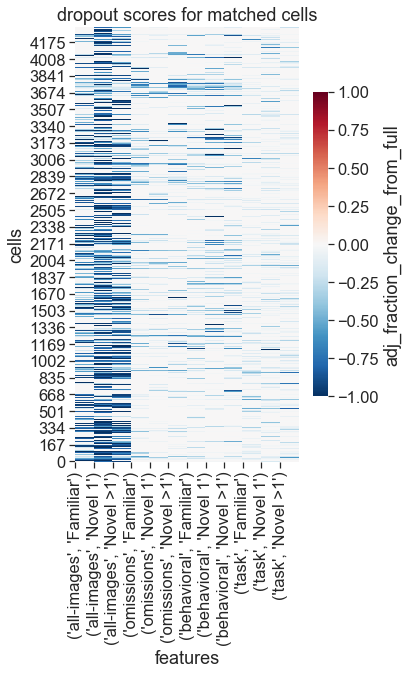

In [30]:
fig, ax = plt.subplots(figsize=(5,8))
ax = sns.heatmap(df.values, cmap='RdBu_r', ax=ax, vmin=-1, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": model_output_type})
ax.set_ylabel('cells')
ax.set_xlabel('features')
ax.set_title('dropout scores for matched cells')
ax.set_ylim(0, df.shape[0])
ax.set_xlim(0, df.shape[1])
ax.set_xticks(np.arange(0, df.shape[1]));
ax.set_xticklabels(df.keys(), rotation=90)
ax.set_xticklabels(df.keys(), rotation=90);

# cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
# for y in cluster_divisions:
#     ax.hlines(y, xmin=0, xmax=df.shape[1], color='k')

### single cell examples

### cluster each cre line

In [31]:
def get_dropouts_across_experience_levels(rspm):
    df = rspm.copy()
    # group by cell_specimen_id and experience level and take the mean (shouldnt actually do anything here because we already filtered for one session of each type)
    df = df.groupby(['cell_specimen_id', 'experience_level']).mean()
    # restrict to the regressors we care about
    df = df[features_to_plot]
    # unstack to turn session number (the last index) into a column level
    df = df.unstack()
    # drop NaN just to be sure, but there shouldnt be any since we should have already filtered to get matched cells
    df = df.dropna()
    return df

In [32]:
df = get_dropouts_across_experience_levels(rspm)
df.head()

all-images                     omissions                     \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1 Novel >1   
cell_specimen_id                                                               
1086489847         0.000000  0.000000  0.000000  0.000000  0.000000      0.0   
1086489860         0.000000 -0.897779  0.000000  0.000000 -0.131552      0.0   
1086489891         0.000000 -0.483451  0.000000 -0.715705 -0.397531      0.0   
1086489976        -0.741136  0.000000 -0.873052  0.000000  0.000000      0.0   
1086490002        -0.734985  0.000000 -0.543915 -0.057500  0.000000      0.0   

                 behavioral                         task                      
experience_level   Familiar   Novel 1 Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                              
1086489847        -0.897361  0.000000     -1.0 -0.006544 -0.044886  0.000000  
1086489860         0.000000  0.000000      0.0  0.000000 -0.037784  0.000000  
1086489891        -0.160694 -0.303837      0.0  0.000000 -0.139572  0.000000  
1086489976         0.000000  0.000000      0.0  0.000000  0.000000 -0.017138  
1086490002        -0.037985  0.000000      0.0 -0.006437  0.000000  0.000000

Excitatory
n 2 clusters mean score = 0.3708254043243473
n 3 clusters mean score = 0.3808796315161277
n 4 clusters mean score = 0.4080715019406065
n 5 clusters mean score = 0.4381224884888882
n 6 clusters mean score = 0.46762827643681365
n 7 clusters mean score = 0.48298842070192693
n 8 clusters mean score = 0.4839688061957622
n 9 clusters mean score = 0.4842957401508935
n 10 clusters mean score = 0.48632142869011474
n 11 clusters mean score = 0.48561332701965326
n 12 clusters mean score = 0.4713027935434718
n 13 clusters mean score = 0.4726507731409967
n 14 clusters mean score = 0.46797184598988883
n 15 clusters mean score = 0.4654833697804389
n 16 clusters mean score = 0.4640808382597027
n 17 clusters mean score = 0.4611824973536997
n 18 clusters mean score = 0.45896044898665533
n 19 clusters mean score = 0.45934409605378673
n 20 clusters mean score = 0.457981699649536
n 21 clusters mean score = 0.458483212432318
n 22 clusters mean score = 0.4588808366035416
n 23 clusters mean score =

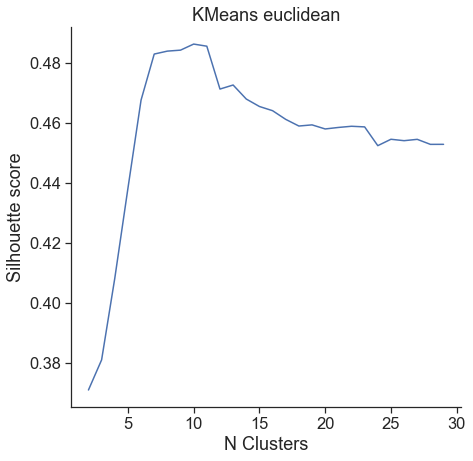

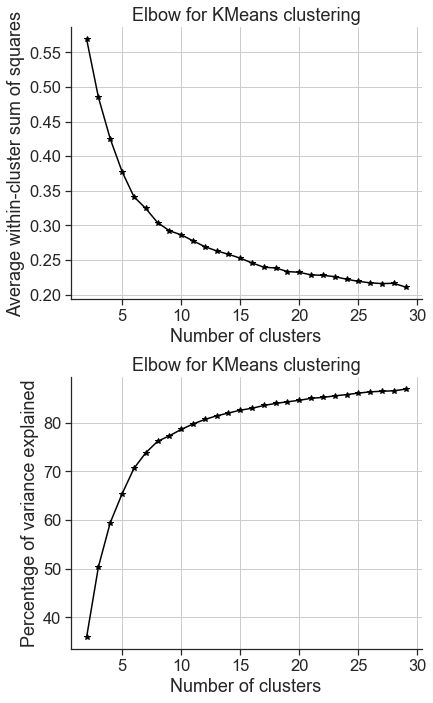

In [52]:
# get restrutured df just for one cell type
cell_type = cell_types[2]
print(cell_type)
df = get_dropouts_across_experience_levels(rspm[rspm.cell_type==cell_type])

# look at silhouette plot
fig, ax = vba_clust.plot_silhouette_scores(df, model=KMeans, n_clusters=np.arange(2, 30), metric='euclidean', n_boots=20,
                         model_output_type='KMeans euclidean')

# look at elbow plot
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
vba_clust.get_elbow_plots(df, n_clusters=np.arange(2, 30), ax=ax)
fig.tight_layout()

In [53]:
# cluster with k-means
X = df.copy()

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

labels = kmeans.labels_
sort_order = np.argsort(labels)
sorted_labels = labels[sort_order]

In [54]:
# create df with cluster_id labels
cluster_df = df.copy()
cluster_df['cluster_id'] = labels

# sort by mean dropout for novel 1 session
mean_df = cluster_df.groupby(['cluster_id']).mean()
sorted_mean_df = mean_df.sort_values(by=[('all-images', 'Novel 1'),('omissions', 'Novel 1'), ('behavioral', 'Novel 1'), ('task', 'Novel 1')])
cluster_order = sorted_mean_df.index.values

# reset labels accordingly
new_order = np.argsort(cluster_order)
new_labels = np.asarray([new_order[label] for label in labels])
new_sort_order = np.argsort(new_labels)
new_sorted_labels = new_labels[new_sort_order]

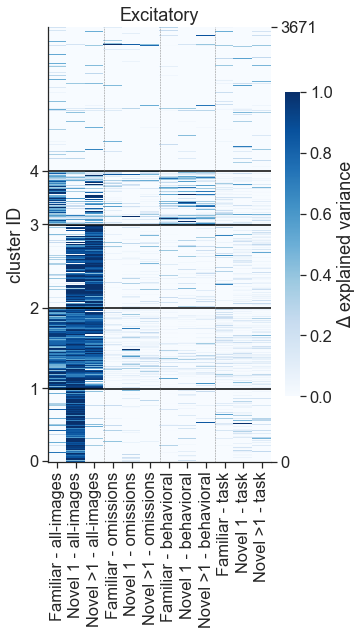

In [55]:
# plot dropout scores sorted by new order
fig, ax = plt.subplots(figsize=(5,8))
ax = sns.heatmap(df.abs().values[new_sort_order], cmap='Blues', ax=ax, vmin=0, vmax=1,
                 robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": '\u0394 explained variance'})
ax.set_ylabel('cells')
ax.set_xlabel('features')
# ax.set_title('k-means on dropout scores')
ax.set_title(cell_type)
ax.set_ylim(0, df.shape[0])
ax.set_xlim(0, df.shape[1])
ax.set_xticks(np.arange(0.5, df.shape[1]+0.5));
# ax.set_xticklabels(df.keys(), rotation=90)
ax.set_xticklabels([key[1]+' - '+key[0] for key in list(df.keys())], rotation=90);
# ax.set_xticklabels([key[0]+' - '+key[1] for key in list(df.keys())], rotation=90);
ax.set_xlabel('')
ax2 = ax.twinx()
ax2.set_yticks([0, len(df)])
ax2.set_yticklabels([0, len(df)])

cluster_divisions = np.where(np.diff(new_sorted_labels)==1)[0]
for y in cluster_divisions:
    ax.hlines(y, xmin=0, xmax=df.shape[1], color='k')
    
ax.set_yticks(np.hstack([np.asarray(0), cluster_divisions])+5);
ax.set_yticklabels(np.sort(cluster_df.cluster_id.unique()));
ax.set_ylabel('cluster ID')

for x in np.arange(0, df.shape[0],3):
    ax.vlines(x, ymin=0, ymax=df.shape[0], color='gray', linestyle='--', linewidth=0.5)
    
# plt.gca().invert_yaxis()

### plot clusters

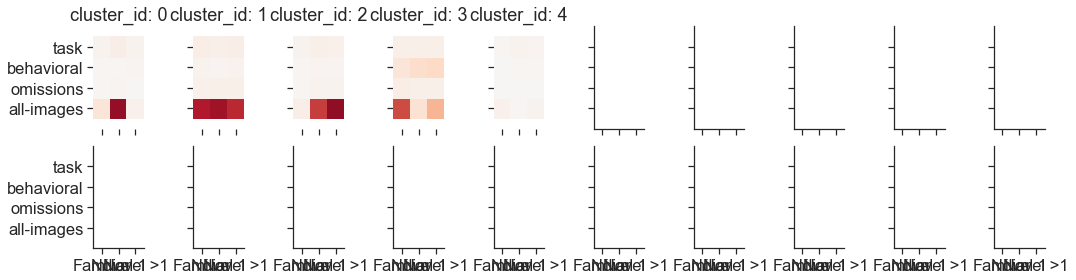

In [56]:
# plot dropouts for clusters
cluster_ids = pd.DataFrame(index=df.index, columns=['cluster_id'], data=new_labels)

cluster_rspm = rspm.merge(cluster_ids, on='cell_specimen_id')

cluster_rspm['cluster_id'] = [int(cluster_id) for cluster_id in cluster_rspm.cluster_id.values]

cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
fig, ax = plt.subplots(2, 10, figsize=(15,4), sharex=True, sharey=True)
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    ax[i].set_title('cluster_id: '+str(cluster_id))
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
#     ax[i].set_
fig.tight_layout()

In [57]:
cluster_df = pd.DataFrame(index=df.index, columns=['cluster_id'], data=new_labels)
print(len(cluster_df))
# merge with metadata
metadata = rspm[['cell_specimen_id', 'cell_type', 'imaging_depth', 'targeted_structure', 'binned_depth']]
cluster_df = cluster_df.merge(metadata, on='cell_specimen_id')
print(len(cluster_df))
cluster_df = cluster_df.drop_duplicates(subset='cell_specimen_id')
print(len(cluster_df))
cluster_df.head()


total_per_cell_type = cluster_df.groupby(['cell_type']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type

n_per_cluster = cluster_df.groupby(['cell_type', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster = n_per_cluster.reset_index()

fraction_per_cluster = n_per_cluster.merge(total_per_cell_type, on=['cell_type'])
fraction_per_cluster['fraction'] = fraction_per_cluster.n_per_cluster.values/fraction_per_cluster.n_total.values

3671
14995
3671


In [58]:
order = np.argsort(fraction_per_cluster.fraction.values)
cluster_order = fraction_per_cluster.cluster_id.values[order][::-1]

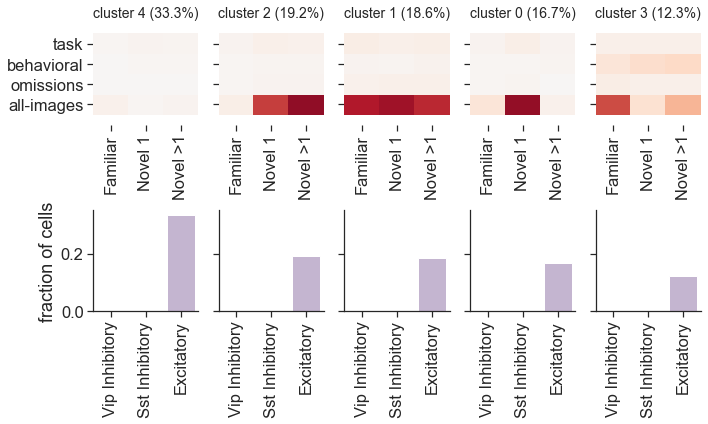

In [59]:
# cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
cluster_ids = cluster_order.copy()
palette = utils.get_cre_line_colors()

n_clusters = len(cluster_ids)

fig, ax = plt.subplots(2, n_clusters, figsize=(n_clusters*2,6), sharex='row', sharey='row')
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    ax[i].set_title('cluster '+str(int(cluster_id))+' ('+str(fraction)+'%)', fontsize=14)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    
    data = fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, 
                                        x='cell_type', y='fraction', #hue='cell_type', 
                                         order=cell_types, #hue_order=cell_types,
                                         palette=palette, ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('fraction of cells')
    ax[i+len(cluster_ids)].set_xlabel('')
#     ax[i+len(cluster_ids)].get_legend().remove()
    ax[i+len(cluster_ids)].set_xticklabels(cell_types, rotation=90)
    
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
    
    
#     ax[i].set_
fig.tight_layout()

### across areas

In [60]:
total_per_cell_type_and_area = cluster_df.groupby(['cell_type', 'targeted_structure']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type_and_area

n_per_cluster_area = cluster_df.groupby(['cell_type', 'targeted_structure', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster_area = n_per_cluster_area.reset_index()

fraction_per_cluster_area = n_per_cluster_area.merge(total_per_cell_type_and_area, on=['cell_type', 'targeted_structure'])
fraction_per_cluster_area['fraction'] = fraction_per_cluster_area.n_per_cluster.values/fraction_per_cluster_area.n_total.values

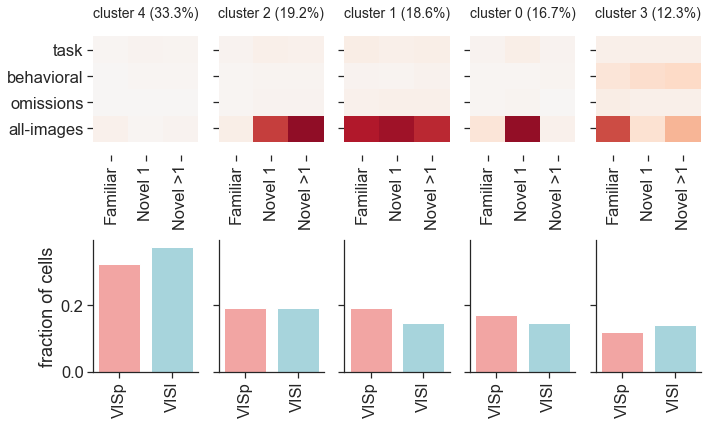

In [61]:
areas = ['VISp', 'VISl']

# cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
cluster_ids = cluster_order.copy()
palette = utils.get_cre_line_colors()

n_clusters = len(cluster_ids)

fig, ax = plt.subplots(2, n_clusters, figsize=(n_clusters*2,6), sharex='row', sharey='row')
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    ax[i].set_title('cluster '+str(int(cluster_id))+' ('+str(fraction)+'%)', fontsize=14)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    
    data = fraction_per_cluster_area[fraction_per_cluster_area.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, 
                                        x='targeted_structure', y='fraction', #hue='cell_type', 
                                         order=areas, #hue_order=cell_types,
                                         palette=palette, ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('fraction of cells')
    ax[i+len(cluster_ids)].set_xlabel('')
#     ax[i+len(cluster_ids)].get_legend().remove()
    ax[i+len(cluster_ids)].set_xticklabels(areas, rotation=90)
    
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
    
    
#     ax[i].set_
fig.tight_layout()

### across depths

In [62]:
depths = [75, 175, 275, 375]

In [63]:
total_per_cell_type_and_depth = cluster_df.groupby(['cell_type', 'binned_depth']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_total'})
total_per_cell_type_and_depth

n_per_cluster_depth = cluster_df.groupby(['cell_type', 'binned_depth', 'cluster_id']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id':'n_per_cluster'})
n_per_cluster_depth = n_per_cluster_depth.reset_index()

# make sure each depth and cluster is represented, even if there are none
for depth in depths: 
    for cluster_id in cluster_ids:
        loc_df = n_per_cluster_depth[(n_per_cluster_depth.binned_depth==depth)&(n_per_cluster_depth.cluster_id==cluster_id)]
        ind = len(n_per_cluster_depth)
        if len(loc_df) == 0:
            n_per_cluster_depth.loc[ind+1, :] = [cell_type, depth, cluster_id, 0]
            
fraction_per_cluster_depth= n_per_cluster_depth.merge(total_per_cell_type_and_depth, on=['cell_type', 'binned_depth'])
fraction_per_cluster_depth['fraction'] = fraction_per_cluster_depth.n_per_cluster.values/fraction_per_cluster_depth.n_total.values

fraction_per_cluster_depth['binned_depth'] = [int(depth) for depth in fraction_per_cluster_depth.binned_depth.values]


Text(0.53, 1.05, 'Excitatory')

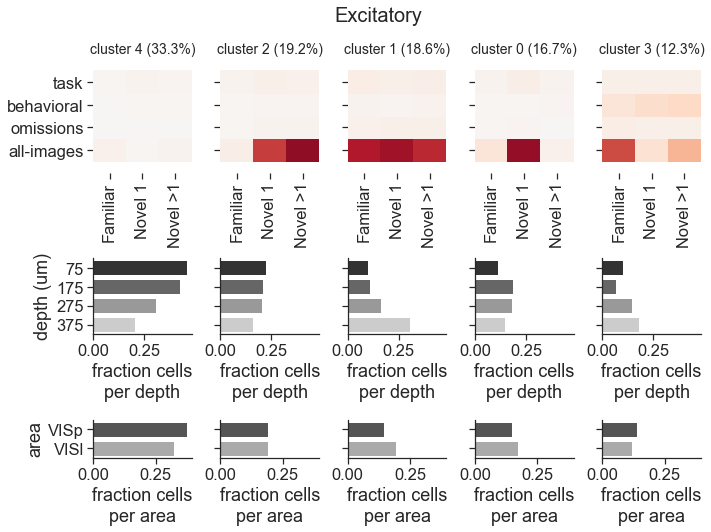

In [64]:
depths = [75, 175, 275, 375]
areas = ['VISp', 'VISl']
# cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
cluster_ids = cluster_order.copy()
# vip_cluster_order = [9, 0, 1, 2, 3, 8, 4, 6, 5, 7]
# cluster_ids = vip_cluster_order
palette = utils.get_cre_line_colors()

n_clusters = len(cluster_ids)

fig, ax = plt.subplots(3, n_clusters, figsize=(n_clusters*2, 7), sharex='row', sharey='row', gridspec_kw={'height_ratios': [3, 2, 1]})
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    ax[i].set_title('cluster '+str(int(cluster_id))+' ('+str(fraction)+'%)', fontsize=14)
    ax[i].set_yticklabels(mean_dropouts_for_cluster.keys(), rotation=0)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    
    data = fraction_per_cluster_depth[fraction_per_cluster_depth.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, orient='h', 
                                        y='binned_depth', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('depth (um)')
    ax[i+len(cluster_ids)].set_xlabel('fraction cells\nper depth')
    ax[i+len(cluster_ids)].set_yticklabels(depths, rotation=0)
    
    data = fraction_per_cluster_area[fraction_per_cluster_area.cluster_id==cluster_id]
    ax[i+(len(cluster_ids)*2)] = sns.barplot(data=data, orient='h', 
                                        y='targeted_structure', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+(len(cluster_ids)*2)])
    ax[i+(len(cluster_ids)*2)].set_ylabel('area')
    ax[i+(len(cluster_ids)*2)].set_xlabel('fraction cells\nper area')
    ax[i+(len(cluster_ids)*2)].set_yticklabels(areas, rotation=0)
    
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
        ax[i+(len(cluster_ids)*2)].set_ylabel('')
    
    
#     ax[i].set_
fig.tight_layout()
plt.suptitle(cell_type, x=0.53, y=1.05, fontsize=20)

### with population averages

#### load multi session df for omissions

In [65]:
%%time

cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir)

# set various params
df_name = 'omission_response_df'
conditions = ['cell_specimen_id']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

multi_session_df = multi_session_df.reset_index(drop=True)

1941
1249
1249
Wall time: 16.6 s


#### set params

In [66]:
cluster_mdf = multi_session_df.merge(cluster_df[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# filter
project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[0] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)
print(len(timestamps))

axes_column = 'cluster_id'
hue_column = 'experience_level'
hue_conditions = np.sort(cluster_mdf[hue_column].unique())
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1,1.5]
change = False
omitted = True
xlabel = 'time (sec)'

sdf = cluster_mdf[cluster_mdf.project_code==project_code].copy()

# remove traces with incorrect length - why does this happen?
sdf = sdf.reset_index(drop=True)
indices = [index for index in sdf.index if len(sdf.iloc[index].mean_trace) == 107]
sdf = sdf.loc[indices]
print(len(sdf.mean_trace.values[0]))


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


107
107
107


Text(0.53, 1.03, 'Excitatory')

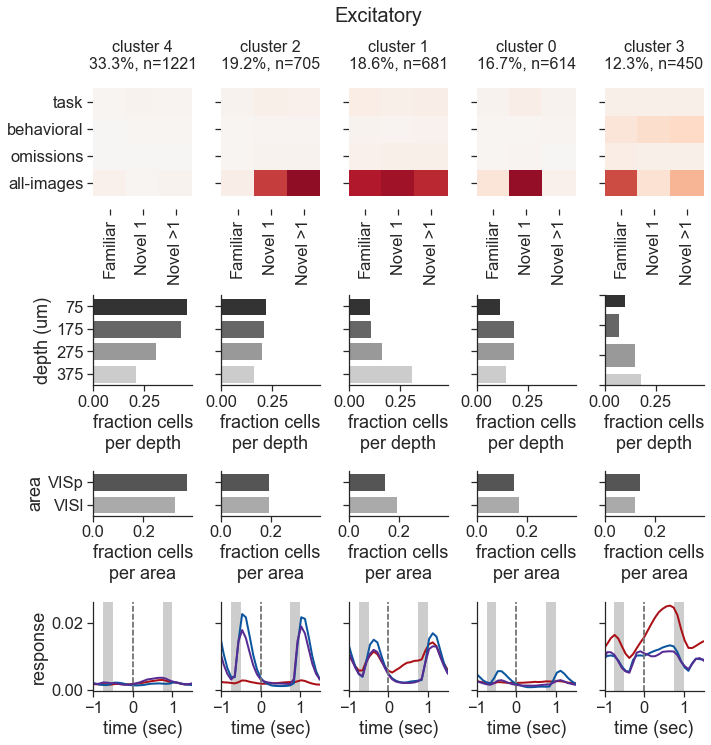

In [67]:
depths = [75, 175, 275, 375]
areas = ['VISp', 'VISl']
# cluster_ids = np.sort(cluster_rspm.cluster_id.unique())
cluster_ids = cluster_order.copy()
# vip_cluster_order = [9, 0, 1, 2, 3, 8, 4, 6, 5, 7]
# cluster_ids = vip_cluster_order
palette = utils.get_experience_level_colors()

n_clusters = len(cluster_ids)

fig, ax = plt.subplots(4, n_clusters, figsize=(n_clusters*2, 10), sharex='row', sharey='row', gridspec_kw={'height_ratios': [3, 2, 1, 2]})
ax = ax.ravel()
for i,cluster_id in enumerate(cluster_ids):
    mean_dropouts_for_cluster = cluster_rspm[cluster_rspm.cluster_id==cluster_id].groupby('experience_level').mean()[features_to_plot]
    ax[i] = sns.heatmap(mean_dropouts_for_cluster.T, cmap='RdBu', vmin=-1, vmax=1, ax=ax[i], cbar=False,)#cbar_kws={'shrink':0.7, 'label':model_output_type})
    fraction = np.round(fraction_per_cluster[fraction_per_cluster.cluster_id==cluster_id].fraction.values[0]*100,1)
    n_cells = int(len(cluster_rspm[cluster_rspm.cluster_id==cluster_id].cell_specimen_id.unique()))
    ax[i].set_title('cluster '+str(int(cluster_id))+'\n'+str(fraction)+'%, n='+str(n_cells), fontsize=16)
    ax[i].set_yticklabels(mean_dropouts_for_cluster.keys(), rotation=0)
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlabel('')
    
    data = fraction_per_cluster_depth[fraction_per_cluster_depth.cluster_id==cluster_id]
    ax[i+len(cluster_ids)] = sns.barplot(data=data, orient='h', 
                                        y='binned_depth', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+len(cluster_ids)])
    ax[i+len(cluster_ids)].set_ylabel('depth (um)')
    ax[i+len(cluster_ids)].set_xlabel('fraction cells\nper depth')
    ax[i+len(cluster_ids)].set_yticks(np.arange(0, len(depths)))
    ax[i+len(cluster_ids)].set_yticklabels(depths, rotation=0)
    
    data = fraction_per_cluster_area[fraction_per_cluster_area.cluster_id==cluster_id]
    ax[i+(len(cluster_ids)*2)] = sns.barplot(data=data, orient='h', 
                                        y='targeted_structure', x='fraction', #hue='cell_type', 
#                                          order=depths, #hue_order=cell_types,
                                         palette='gray', ax=ax[i+(len(cluster_ids)*2)])
    ax[i+(len(cluster_ids)*2)].set_ylabel('area')
    ax[i+(len(cluster_ids)*2)].set_xlabel('fraction cells\nper area')
    ax[i+(len(cluster_ids)*2)].set_yticklabels(areas, rotation=0)
    
    # plot mean traces
    for c, hue in enumerate(hue_conditions):

        traces = sdf[(sdf['cluster_id'] == cluster_id) & (sdf[hue_column] == hue)].mean_trace.values
        ax[i+(len(cluster_ids)*3)] = utils.plot_mean_trace(np.asarray(traces), timestamps, ylabel='response',
                                      legend_label=hue, color=palette[c], interval_sec=1, plot_sem=False,
                                      xlim_seconds=xlim_seconds, ax=ax[i+(len(cluster_ids)*3)])
        ax[i+(len(cluster_ids)*3)] = utils.plot_flashes_on_trace(ax[i+(len(cluster_ids)*3)], timestamps, change=change, omitted=omitted)
        ax[i+(len(cluster_ids)*3)].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
        ax[i+(len(cluster_ids)*3)].set_title('')
        ax[i+(len(cluster_ids)*3)].set_xlim(xlim_seconds)
        ax[i+(len(cluster_ids)*3)].set_xlabel(xlabel)
            
    if i != 0:
        ax[i+len(cluster_ids)].set_ylabel('')
        ax[i+(len(cluster_ids)*2)].set_ylabel('')
        ax[i+(len(cluster_ids)*3)].set_ylabel('') 
    
#     ax[i].set_
fig.tight_layout()
plt.suptitle(cell_type, x=0.53, y=1.03, fontsize=20)